In [1]:
# Taken from
# https://stackoverflow.com/questions/2358045/how-can-i-implement-a-tree-in-python-are-there-any-built-in-data-structures-in
from collections import MutableMapping
import random

class RandomChoiceDict(MutableMapping):
    """
    Dictionary-like object allowing efficient random selection.

    """
    def __init__(self):
        # Add code to initialize from existing dictionaries.
        self._keys = []
        self._values = []
        self._key_to_index = {}

    def __getitem__(self, key):
        return self._values[self._key_to_index[key]]

    def __setitem__(self, key, value):
        try:
            index = self._key_to_index[key]
        except KeyError:
            # Key doesn't exist; add a new one.
            index = len(self._keys)
            self._key_to_index[key] = index
            self._keys.append(key)
            self._values.append(value)
        else:
            # Key already exists; overwrite the value.
            self._values[index] = value

    def __delitem__(self, key):
        index = self._key_to_index.pop(key)
        # Remove *last* indexed element, then put
        # it back at position 'index' (overwriting the
        # one we're actually removing) if necessary.
        key, value = self._keys.pop(), self._values.pop()
        if index != len(self._key_to_index):
            self._keys[index] = key
            self._values[index] = value
            self._key_to_index[key] = index

    def __len__(self):
        return len(self._key_to_index)

    def __iter__(self):
        return iter(self._keys)

    def random_key(self):
        """Return a randomly chosen key."""
        if not self:
            raise KeyError("Empty collection")
        index = random.randrange(len(self))
        return self._keys[index]

    def popitem_random(self):
        key = self.random_key()
        value = self.pop(key)
        return key, value

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
import seaborn as sns
sns.set()


class memory_cell():
    """
    Memory cell to store the impression of another agent is simply its defection rate
    
    Attributes
    ------------
    defect_number_ : Number of defection
    play_number_   : Number of Plays
    
    """
    def __init__(self, act = 'C'):
        self.defect_number_ = 0
        self.play_number_ = 1
        
        if act == 'D' : self.defect_number_ += 1
    
    def update(self, act):
        if act == 'D' : self.defect_number_ += 1
        self.play_number_ += 1
    
    def impression(self):
        return self.defect_number_/max(1, self.play_number_)
    
class agent():
    """
    Player of a Prisoners Dilemma Game. 
    
    Parameters
    ------------
    ID            : Unique identifier for the agent
    pd            : Probability of defection
    capacity      : Memory Size/Capacity 
    
        
    Attributes
    ------------
    score_                  : Accumulates payoffs (define success/fitness)
    memory_for_defectors_   : 
    memory_for_cooperators_ :
                 Store information about a limited number (M) of opponent players.
                 Dictionary (key, value) = (other_agent, memory_cell)
    
    """
    def __init__(self, ID, pd = 1, M = 1):
        self.ID = ID
        self.pd = pd
        self.capacity = M
        self.score_ = 0
        
        self.memory_for_defectors_ = RandomChoiceDict()
        self.memory_for_cooperators_ = RandomChoiceDict()
        
    def act(self):
        """
        Two possible actions
            - defect with probability pd
            - cooperate with probability 1 - pd
        """
        if np.random.rand() < self.pd:
            return 'D'
        return 'C'
    
    def know(self, other):
        return (other in self.memory_for_defectors_) or (other in self.memory_for_cooperators_)
    
    def is_memory_full(self):
        c,d = len(self.memory_for_cooperators_), len(self.memory_for_defectors_)
        return  c + d >= self.capacity
    
    def perceive_as_defector(self, other):
        return other in self.memory_for_defectors_
    
    def take_payoff(self, payoff):
        self.score_ += payoff
    
    def learn(self, other, act):  
        if other in self.memory_for_defectors_:
            print("-- Bug -- Dont play with a defector!! -- ")
        elif other in self.memory_for_cooperators_:
            self.memory_for_cooperators_[other].update(act)
            
            # a cooperator became a defector!
            if self.memory_for_cooperators_[other].impression() > 0.5:
                self.memory_for_defectors_[other] = self.memory_for_cooperators_[other]
                del self.memory_for_cooperators_[other]
        else: # first play with an unknown player
            if self.is_memory_full(): 
                self.forget()
            if act == 'C':
                self.memory_for_cooperators_[other] = memory_cell(act)
            else:
                self.memory_for_defectors_[other] = memory_cell(act)
        
    def forget(self):   
        if len(self.memory_for_cooperators_) > 0:
            self.memory_for_cooperators_.popitem_random()
        else:
            self.memory_for_defectors_.popitem_random()

    def display(self):
        return [(k.ID, v.impression()) for (k,v) in self.memory_for_cooperators_.items()] + [(k.ID, v.impression()) for (k,v) in self.memory_for_defectors_.items()]
    
    

In [3]:
class abm():
    def __init__(self, N = 10, M = 9, tau = 5, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [agent(i, pd = np.random.rand(), M = M) for i in range(self.N)]
        self.payoff = payoff
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.take_payoff(self.payoff[A_action+B_action])
            B.take_payoff(self.payoff[B_action+A_action])
            
    def display(self):
        df = pd.DataFrame(columns=['ID','pD', 'score', 'M', 'Memory Len', 'Memory'])
        for A in self.population:
            df.loc[A.ID] = pd.Series({'ID':A.ID, 'pD':A.pd, 'score':A.score_, 'M': A.capacity, 
                                      'Memory Len': len(A.memory_for_cooperators_) + len(A.memory_for_defectors_), 
                                      'Memory':A.display()})
        return df

# Simulation

In [4]:
N = 100
M = 50
sim = abm(N, M)
sim.world()
result = sim.display()
result.head(3)

,ID,pD,score,M,Memory Len,Memory
0,0,0.270467,705,50,50,"[(77, 0.0), (40, 1.0), (29, 1.0), (47, 1.0), (..."
1,1,0.572742,552,50,50,"[(18, 0.0), (30, 1.0), (6, 1.0), (44, 1.0), (8..."
2,2,0.406095,632,50,50,"[(34, 1.0), (23, 1.0), (51, 1.0), (16, 1.0), (..."


In [5]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 6 columns):
ID            100 non-null object
pD            100 non-null float64
score         100 non-null object
M             100 non-null object
Memory Len    100 non-null object
Memory        100 non-null object
dtypes: float64(1), object(5)
memory usage: 5.5+ KB


# Data Analysis

In [6]:
def makeDict(T):
    return {t[0]:t[1] for t in T}

data = list(result.Memory.apply(makeDict))
df = pd.DataFrame(data).fillna(0)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


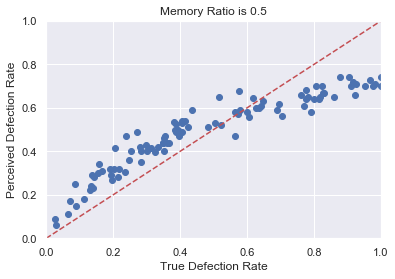

In [7]:
perception = df.mean(axis = 0)
plt.plot(result.pD[perception.index] , perception, 'o')
plt.xlabel('True Defection Rate')
plt.ylabel('Perceived Defection Rate')
plt.title("Memory Ratio is {}".format(M/N))
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.show()

# Do Some Analysis

In [13]:
import time
start = time.time()

N = 100
Ms = [5, 25, 50, 75, 85, 99]
results = []
dfs = []

for M in Ms:
    sim = abm(N, M)
    sim.world()
    result = sim.display()
    results.append(result)
    
    data = list(result.Memory.apply(makeDict))
    df = pd.DataFrame(data).fillna(0)
    dfs.append(df)
    
end = time.time()
print(end - start)

13.994179725646973


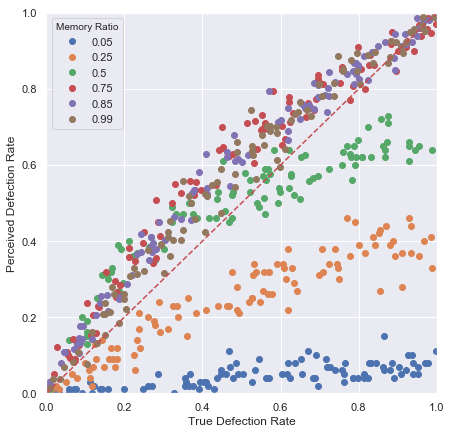

In [9]:
plt.figure(figsize = (7,7))
for k in range(len(Ms)):
    perception = dfs[k].mean(axis = 0)
    result = results[k]
    plt.plot(result.pD[perception.index] , perception, 'o')
    plt.xlabel('True Defection Rate')
    plt.ylabel('Perceived Defection Rate')
plt.legend(np.array(Ms)/N,title = "Memory Ratio")

plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.show()